# Data Prep

## Import Libraries


In [391]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import lightgbm
from lightgbm import LGBMClassifier


from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import precision_score, recall_score, roc_auc_score, roc_curve

from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report, confusion_matrix
import itertools


RSEED=42

pd.set_option('display.float_format', lambda x: '%.5f' % x)

import warnings
warnings.simplefilter('ignore')

## Read the Data

In [392]:
client_train = pd.read_csv('data/client_train.csv', low_memory=False)
invoice_train = pd.read_csv('data/invoice_train.csv', low_memory=False)

client_test = pd.read_csv('data/test/client_test.csv', low_memory=False)
invoice_test = pd.read_csv('data/test/invoice_test.csv', low_memory=False)
sample_submission = pd.read_csv('data/SampleSubmission.csv', low_memory=False)

## Data Understanding

In [393]:
#compare size of the various datasets
print(client_train.shape, invoice_train.shape, client_test.shape, invoice_train.shape)

(135493, 6) (4476749, 16) (58069, 5) (4476749, 16)


In [394]:
#print top rows of dataset
invoice_train.head()

,client_id,invoice_date,tarif_type,counter_number,counter_statue,counter_code,reading_remarque,counter_coefficient,consommation_level_1,consommation_level_2,consommation_level_3,consommation_level_4,old_index,new_index,months_number,counter_type
0,train_Client_0,2014-03-24,11,1335667,0,203,8,1,82,0,0,0,14302,14384,4,ELEC
1,train_Client_0,2013-03-29,11,1335667,0,203,6,1,1200,184,0,0,12294,13678,4,ELEC
2,train_Client_0,2015-03-23,11,1335667,0,203,8,1,123,0,0,0,14624,14747,4,ELEC
3,train_Client_0,2015-07-13,11,1335667,0,207,8,1,102,0,0,0,14747,14849,4,ELEC
4,train_Client_0,2016-11-17,11,1335667,0,207,9,1,572,0,0,0,15066,15638,12,ELEC


In [395]:
#print top rows of dataset
client_train.head()

,disrict,client_id,client_catg,region,creation_date,target
0,60,train_Client_0,11,101,31/12/1994,0.00000
1,69,train_Client_1,11,107,29/05/2002,0.00000
2,62,train_Client_10,11,301,13/03/1986,0.00000
3,69,train_Client_100,11,105,11/07/1996,0.00000
4,62,train_Client_1000,11,303,14/10/2014,0.00000


In [396]:
#Get a summary for all numerical columns
invoice_train.describe()

,tarif_type,counter_number,counter_code,reading_remarque,counter_coefficient,consommation_level_1,consommation_level_2,consommation_level_3,consommation_level_4,old_index,new_index,months_number
count,4476749.00000,4476749.00000,4476749.00000,4476749.00000,4476749.00000,4476749.00000,4476749.00000,4476749.00000,4476749.00000,4476749.00000,4476749.00000,4476749.00000
mean,20.12804,123058699065.18332,172.48843,7.32170,1.00304,410.97950,109.32248,20.30620,52.92588,17766.99826,18349.70462,44.83095
std,13.47256,1657267274261.92676,133.88710,1.57165,0.30835,757.30800,1220.12334,157.42394,875.47248,40366.92561,40953.20625,3128.33539
min,8.00000,0.00000,0.00000,5.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000
25%,11.00000,121108.00000,5.00000,6.00000,1.00000,79.00000,0.00000,0.00000,0.00000,1791.00000,2056.00000,4.00000
50%,11.00000,494561.00000,203.00000,8.00000,1.00000,274.00000,0.00000,0.00000,0.00000,7690.00000,8192.00000,4.00000
75%,40.00000,1115161.00000,207.00000,9.00000,1.00000,600.00000,0.00000,0.00000,0.00000,21660.00000,22343.00000,4.00000
max,45.00000,27981145458733.00000,600.00000,413.00000,50.00000,999910.00000,999073.00000,64492.00000,547946.00000,2800280.00000,2870972.00000,636624.00000


In [397]:
#Get a summary for all numerical columns
client_train.describe()

,disrict,client_catg,region,target
count,135493.00000,135493.00000,135493.00000,135493.00000
mean,63.51122,11.51251,206.15981,0.05584
std,3.35440,4.42376,104.20704,0.22961
min,60.00000,11.00000,101.00000,0.00000
25%,62.00000,11.00000,103.00000,0.00000
50%,62.00000,11.00000,107.00000,0.00000
75%,69.00000,11.00000,307.00000,0.00000
max,69.00000,51.00000,399.00000,1.00000


In [398]:
#Get concise information of each column in dataset
invoice_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4476749 entries, 0 to 4476748
Data columns (total 16 columns):
 #   Column                Dtype 
---  ------                ----- 
 0   client_id             object
 1   invoice_date          object
 2   tarif_type            int64 
 3   counter_number        int64 
 4   counter_statue        object
 5   counter_code          int64 
 6   reading_remarque      int64 
 7   counter_coefficient   int64 
 8   consommation_level_1  int64 
 9   consommation_level_2  int64 
 10  consommation_level_3  int64 
 11  consommation_level_4  int64 
 12  old_index             int64 
 13  new_index             int64 
 14  months_number         int64 
 15  counter_type          object
dtypes: int64(12), object(4)
memory usage: 546.5+ MB


In [399]:
#Get concise information of each column in dataset
client_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 135493 entries, 0 to 135492
Data columns (total 6 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   disrict        135493 non-null  int64  
 1   client_id      135493 non-null  object 
 2   client_catg    135493 non-null  int64  
 3   region         135493 non-null  int64  
 4   creation_date  135493 non-null  object 
 5   target         135493 non-null  float64
dtypes: float64(1), int64(3), object(2)
memory usage: 6.2+ MB


In [400]:
#Getting unique values on the invoice train data
for col in invoice_train.columns:
    print(f"{col} - {invoice_train[col].nunique()}")

client_id - 135493
invoice_date - 8275
tarif_type - 17
counter_number - 201893
counter_statue - 12
counter_code - 42
reading_remarque - 8
counter_coefficient - 16
consommation_level_1 - 8295
consommation_level_2 - 12576
consommation_level_3 - 2253
consommation_level_4 - 12075
old_index - 155648
new_index - 157980
months_number - 1370
counter_type - 2


In [401]:
#Getting unique values on the invoice train data
for col in client_train.columns:
    print(f"{col} - {client_train[col].nunique()}")

disrict - 4
client_id - 135493
client_catg - 3
region - 25
creation_date - 8088
target - 2


In [402]:
#check for missing values
invoice_train.isnull().sum()

client_id               0
invoice_date            0
tarif_type              0
counter_number          0
counter_statue          0
counter_code            0
reading_remarque        0
counter_coefficient     0
consommation_level_1    0
consommation_level_2    0
consommation_level_3    0
consommation_level_4    0
old_index               0
new_index               0
months_number           0
counter_type            0
dtype: int64

In [403]:
#check for missing values
client_train.isnull().sum()

disrict          0
client_id        0
client_catg      0
region           0
creation_date    0
target           0
dtype: int64

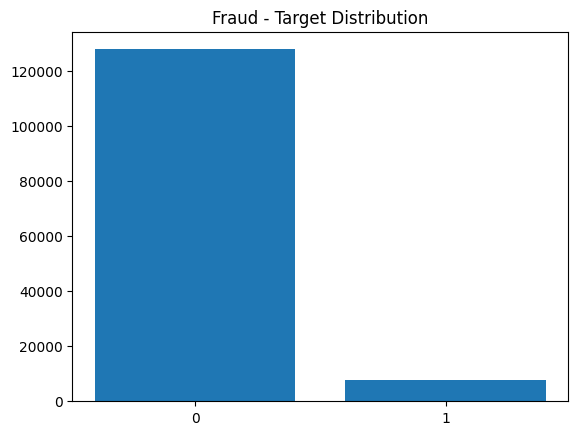

In [404]:
#Visualize fraudulent activities
fraudactivities = client_train.groupby(['target'])['client_id'].count()
plt.bar(x=fraudactivities.index, height=fraudactivities.values, tick_label = [0,1])
plt.title('Fraud - Target Distribution')
plt.show()

In [405]:
client_train[client_train.target == 1].shape[0]

7566

In [406]:
client_train[client_train.target == 1].shape[0]/client_train.shape[0]

0.05584052312665599

## Feature Engineering

In [407]:
#convert the column creation_date to date time format on both the client train and client test
for df in [client_train,client_test]:
    df['creation_date'] = pd.to_datetime(df['creation_date'])

#convert the column invoice_date to date time format on both the invoice train and invoice test
for df in [invoice_train,invoice_test]:
    df['invoice_date'] = pd.to_datetime(df['invoice_date'])

In [408]:
#encode labels in categorical column
d={"ELEC":0,"GAZ":1}
invoice_train['counter_type']=invoice_train['counter_type'].map(d)
invoice_test['counter_type']=invoice_test['counter_type'].map(d)

In [409]:
#convert categorical columns to int for model
client_train['client_catg'] = client_train['client_catg'].astype(int)
client_train['disrict'] = client_train['disrict'].astype(int)

client_test['client_catg'] = client_test['client_catg'].astype(int)
client_test['disrict'] = client_test['disrict'].astype(int)

In [410]:
## ELEC
#invoice_train = invoice_train[invoice_train.counter_type == 0]

In [411]:
invoice_train.shape[0]

4476749

In [412]:
# invoice_train['cons1'] = np.where(invoice_train.consommation_level_1 > invoice_train.months_number*200,\
#                                   (invoice_train.consommation_level_1-invoice_train.months_number*200),0)
# invoice_train['cons2'] = np.where(invoice_train.consommation_level_2 > invoice_train.months_number*100,\
#                                   (invoice_train.consommation_level_2-invoice_train.months_number*100),0)
# invoice_train['cons3'] = np.where(invoice_train.consommation_level_3 > invoice_train.months_number*200,\
#                                   (invoice_train.consommation_level_3-invoice_train.months_number*200),0)
# invoice_train['cons_fraud'] = invoice_train['cons1'] + invoice_train['cons2'] + invoice_train['cons3']

In [413]:
invoice_train['dif_cons_elec'] = invoice_train[invoice_train.counter_type==0].new_index - invoice_train[invoice_train.counter_type==0].old_index\
- invoice_train[invoice_train.counter_type==0].consommation_level_1\
- invoice_train[invoice_train.counter_type==0].consommation_level_2\
- invoice_train[invoice_train.counter_type==0].consommation_level_3\
- invoice_train[invoice_train.counter_type==0].consommation_level_4
invoice_train['dif_cons_gaz'] = invoice_train[invoice_train.counter_type==1].new_index - invoice_train[invoice_train.counter_type==1].old_index\
- invoice_train[invoice_train.counter_type==1].consommation_level_1\
- invoice_train[invoice_train.counter_type==1].consommation_level_2\
- invoice_train[invoice_train.counter_type==1].consommation_level_3\
- invoice_train[invoice_train.counter_type==1].consommation_level_4


In [414]:
def aggregate_by_client_id(invoice_data):
    aggs = {}
#     aggs['consommation_level_1'] = ['max']
#     aggs['consommation_level_2'] = ['max']
#     aggs['consommation_level_3'] = ['max']
#     aggs['consommation_level_4'] = ['max']
    aggs['dif_cons_elec'] = ['sum']
    aggs['dif_cons_gaz'] = ['sum']    
    aggs['invoice_date'] = ['max']
    #aggs['months_number'] = ['sum']
    #aggs['cons_fraud'] = ['sum']
    

    agg_trans = invoice_data.groupby(['client_id']).agg(aggs)
    agg_trans.columns = ['_'.join(col).strip() for col in agg_trans.columns.values]
    agg_trans.reset_index(inplace=True)

    df = (invoice_data.groupby('client_id')
            .size()
            .reset_index(name='transactions_count'))
    

    return pd.merge(df, agg_trans, on='client_id', how='left')

In [415]:
# df = (invoice_data.groupby('client_id')
#             .size()
#             .reset_index(name='{}transactions_count'.format('1')))
# df   

In [416]:
#group invoice data by client_id
agg_train = aggregate_by_client_id(invoice_train)

In [417]:
#merge aggregate data with client dataset
train = pd.merge(client_train,agg_train, on='client_id', how='left')
#train['date_difference'] = train.invoice_date_max-train.creation_date
#train['date_difference']=round(train.date_difference.dt.total_seconds()/60/60/24/30)
#train['dif_count']=train.date_difference/train.transactions_count
#train['creation_maxinv_dif']=(train.invoice_date_max-train.creation_date)
#train['months_number_sum'] = train.months_number_sum*30
#train['dif_months_n'] = train['months_number_sum'] - train['date_difference']


In [418]:
print(agg_train.shape)
agg_train.head()

(135493, 5)


,client_id,transactions_count,dif_cons_elec_sum,dif_cons_gaz_sum,invoice_date_max
0,train_Client_0,35,0.00000,0.00000,2019-03-19
1,train_Client_1,37,0.00000,0.00000,2019-04-02
2,train_Client_10,18,0.00000,0.00000,2019-05-02
3,train_Client_100,20,0.00000,0.00000,2012-09-25
4,train_Client_1000,14,0.00000,0.00000,2019-06-17


In [419]:
#aggregate test set
# invoice_test = 
# agg_test = aggregate_by_client_id(invoice_test)
# test = pd.merge(client_test,agg_test, on='client_id', how='left')

In [420]:
train.shape, test.shape

((135493, 10), (58069, 10))

In [421]:
# #drop redundant columns
# sub_client_id = test['client_id']
# drop_columns = ['client_id', 'creation_date']

# for col in drop_columns:
#     if col in train.columns:
#         train.drop([col], axis=1, inplace=True)
#     if col in test.columns:
#         test.drop([col], axis=1, inplace=True)

In [422]:
train[(train.dif_cons_gaz_sum>0)&(train.target == 1)]

,disrict,client_id,client_catg,region,creation_date,target,transactions_count,dif_cons_elec_sum,dif_cons_gaz_sum,invoice_date_max
8152,69,train_Client_107333,11,107,1996-11-25,1.00000,51,0.00000,269.00000,2019-12-06
8233,60,train_Client_107406,11,101,2001-04-27,1.00000,77,0.00000,135.00000,2019-08-07
17019,62,train_Client_115313,51,307,2013-04-18,1.00000,22,0.00000,3525.00000,2019-03-09
19220,69,train_Client_117295,11,107,1979-12-29,1.00000,41,0.00000,60.00000,2019-04-02
30426,62,train_Client_127380,11,304,1982-11-03,1.00000,72,0.00000,68.00000,2019-06-25
31718,63,train_Client_128543,11,311,2009-10-23,1.00000,53,0.00000,4.00000,2019-04-02
33707,69,train_Client_130332,11,107,1998-05-19,1.00000,57,0.00000,47.00000,2019-07-02
34532,63,train_Client_131075,51,372,2010-06-30,1.00000,75,0.00000,12616217.00000,2019-10-06
40423,63,train_Client_14434,11,308,2000-12-29,1.00000,55,0.00000,1.00000,2019-02-27
40807,63,train_Client_14780,51,312,2003-04-30,1.00000,231,5509560.00000,19679956.00000,2019-10-06


In [423]:
train

,disrict,client_id,client_catg,region,creation_date,target,transactions_count,dif_cons_elec_sum,dif_cons_gaz_sum,invoice_date_max
0,60,train_Client_0,11,101,1994-12-31,0.00000,35,0.00000,0.00000,2019-03-19
1,69,train_Client_1,11,107,2002-05-29,0.00000,37,0.00000,0.00000,2019-04-02
2,62,train_Client_10,11,301,1986-03-13,0.00000,18,0.00000,0.00000,2019-05-02
3,69,train_Client_100,11,105,1996-07-11,0.00000,20,0.00000,0.00000,2012-09-25
4,62,train_Client_1000,11,303,2014-10-14,0.00000,14,0.00000,0.00000,2019-06-17
...,...,...,...,...,...,...,...,...,...,...
135488,62,train_Client_99995,11,304,2004-07-26,0.00000,71,0.00000,-139.00000,2019-06-26
135489,63,train_Client_99996,11,311,2012-10-25,0.00000,41,0.00000,0.00000,2019-06-18
135490,63,train_Client_99997,11,311,2011-11-22,0.00000,36,0.00000,0.00000,2019-11-06
135491,60,train_Client_99998,11,101,1993-12-22,0.00000,2,0.00000,0.00000,2005-12-19


In [424]:
train.columns

Index(['disrict', 'client_id', 'client_catg', 'region', 'creation_date',
       'target', 'transactions_count', 'dif_cons_elec_sum', 'dif_cons_gaz_sum',
       'invoice_date_max'],
      dtype='object')

disrict
client_catg
region
creation_date
target
transactions_count
dif_cons_elec_sum
dif_cons_gaz_sum
invoice_date_max


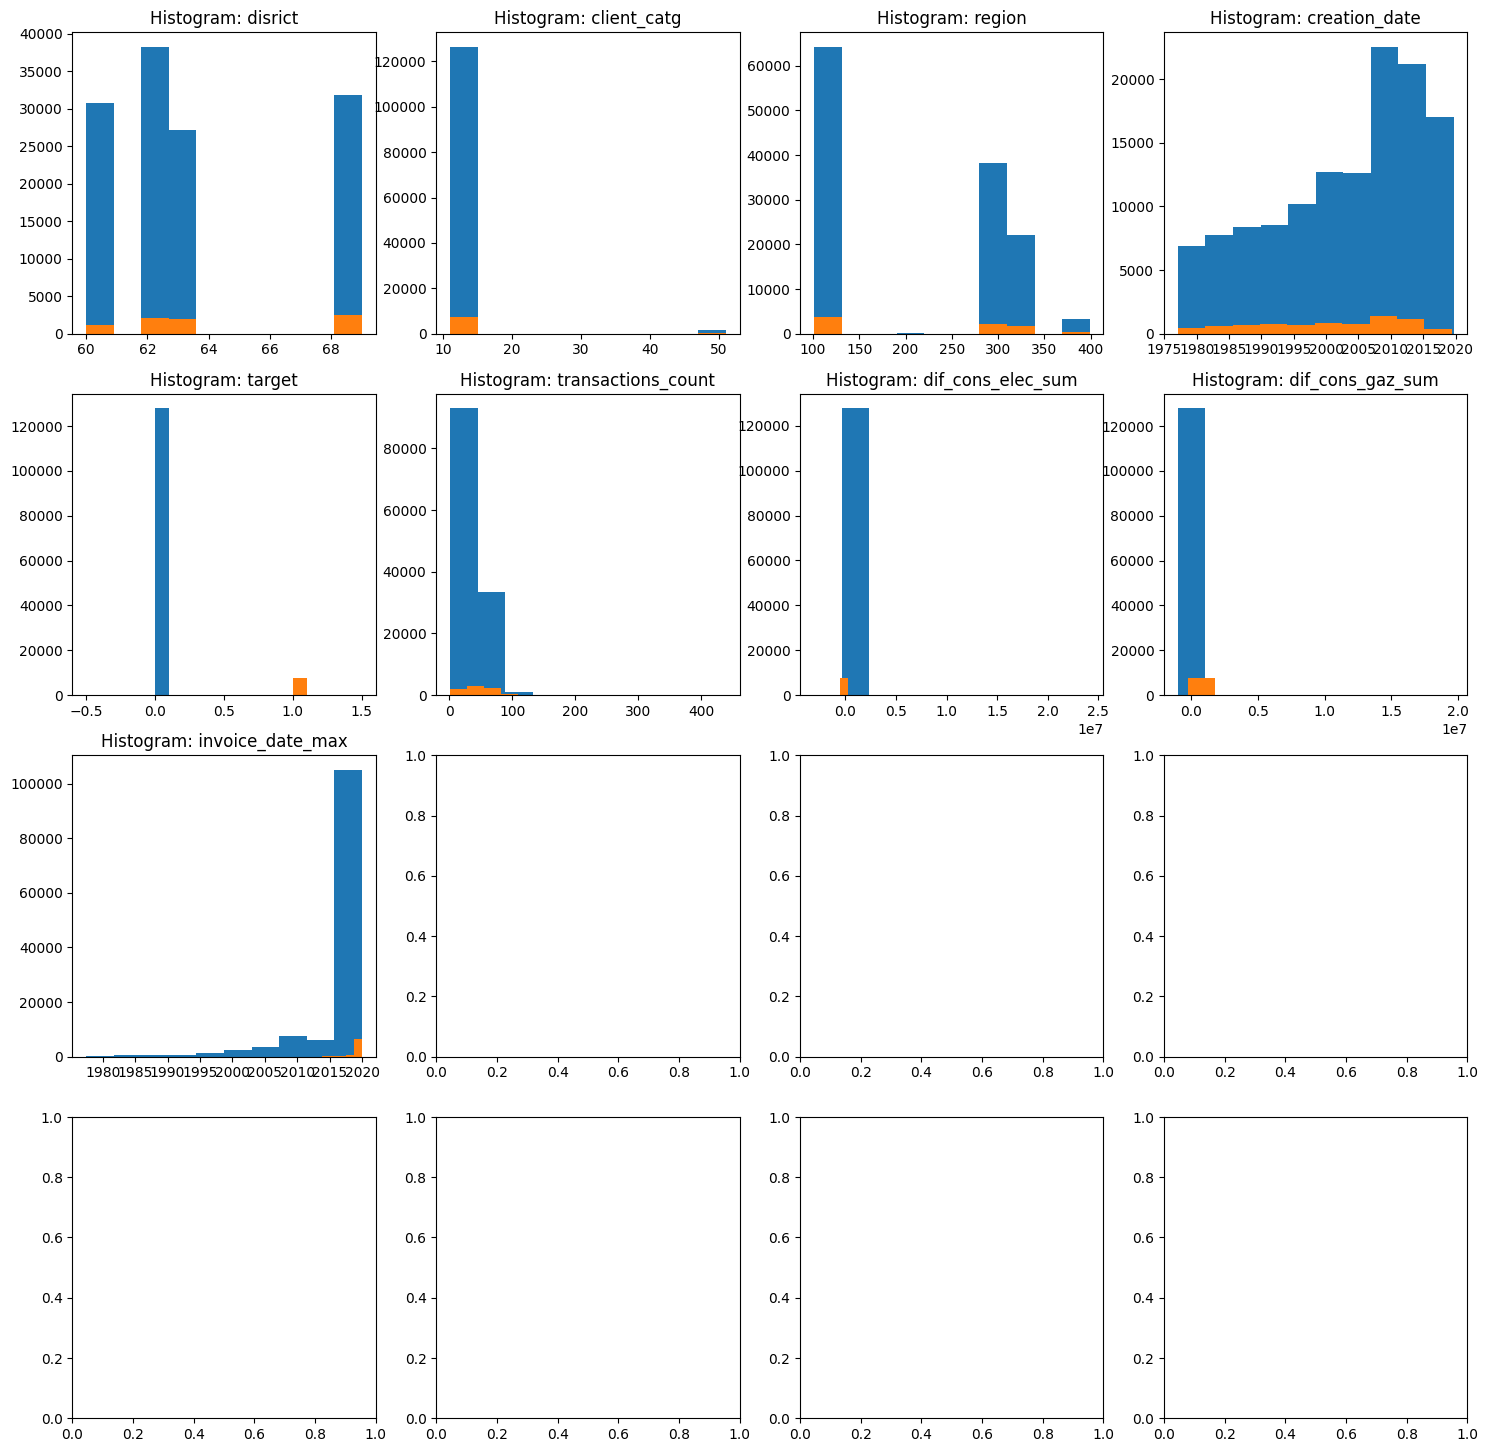

In [425]:
num_cols = ['disrict', 'client_catg', 'region', 'creation_date',
       'target', 'transactions_count', 'dif_cons_elec_sum', 'dif_cons_gaz_sum',
       'invoice_date_max']

def histplot_target(train,num_cols,nrows,ncolumns):

    fig, ax = plt.subplots(nrows, ncolumns,figsize=(18,18))
    ax = ax.ravel()

    for i in range(len(num_cols)):
        print(num_cols[i])
        ax[i].set_title('Histogram: ' + num_cols[i])
        ax[i].hist(train.loc[train.target == 0, num_cols[i]])
        ax[i].hist(train.loc[train.target == 1, num_cols[i]])
    
    plt.show()

histplot_target(train,num_cols,4,4)


In [426]:
train.loc[train.target == 1,['dif_cons_elec_sum','dif_cons_gaz_sum']].describe()

,dif_cons_elec_sum,dif_cons_gaz_sum
count,7566.00000,7566.00000
mean,-2309.60204,4013.45004
std,70734.72956,268797.41035
min,-2000000.00000,-210000.00000
25%,0.00000,0.00000
50%,0.00000,0.00000
75%,0.00000,0.00000
max,5509560.00000,19679956.00000


disrict
client_catg
region
creation_date
target
transactions_count
dif_cons_elec_sum
dif_cons_gaz_sum
invoice_date_max


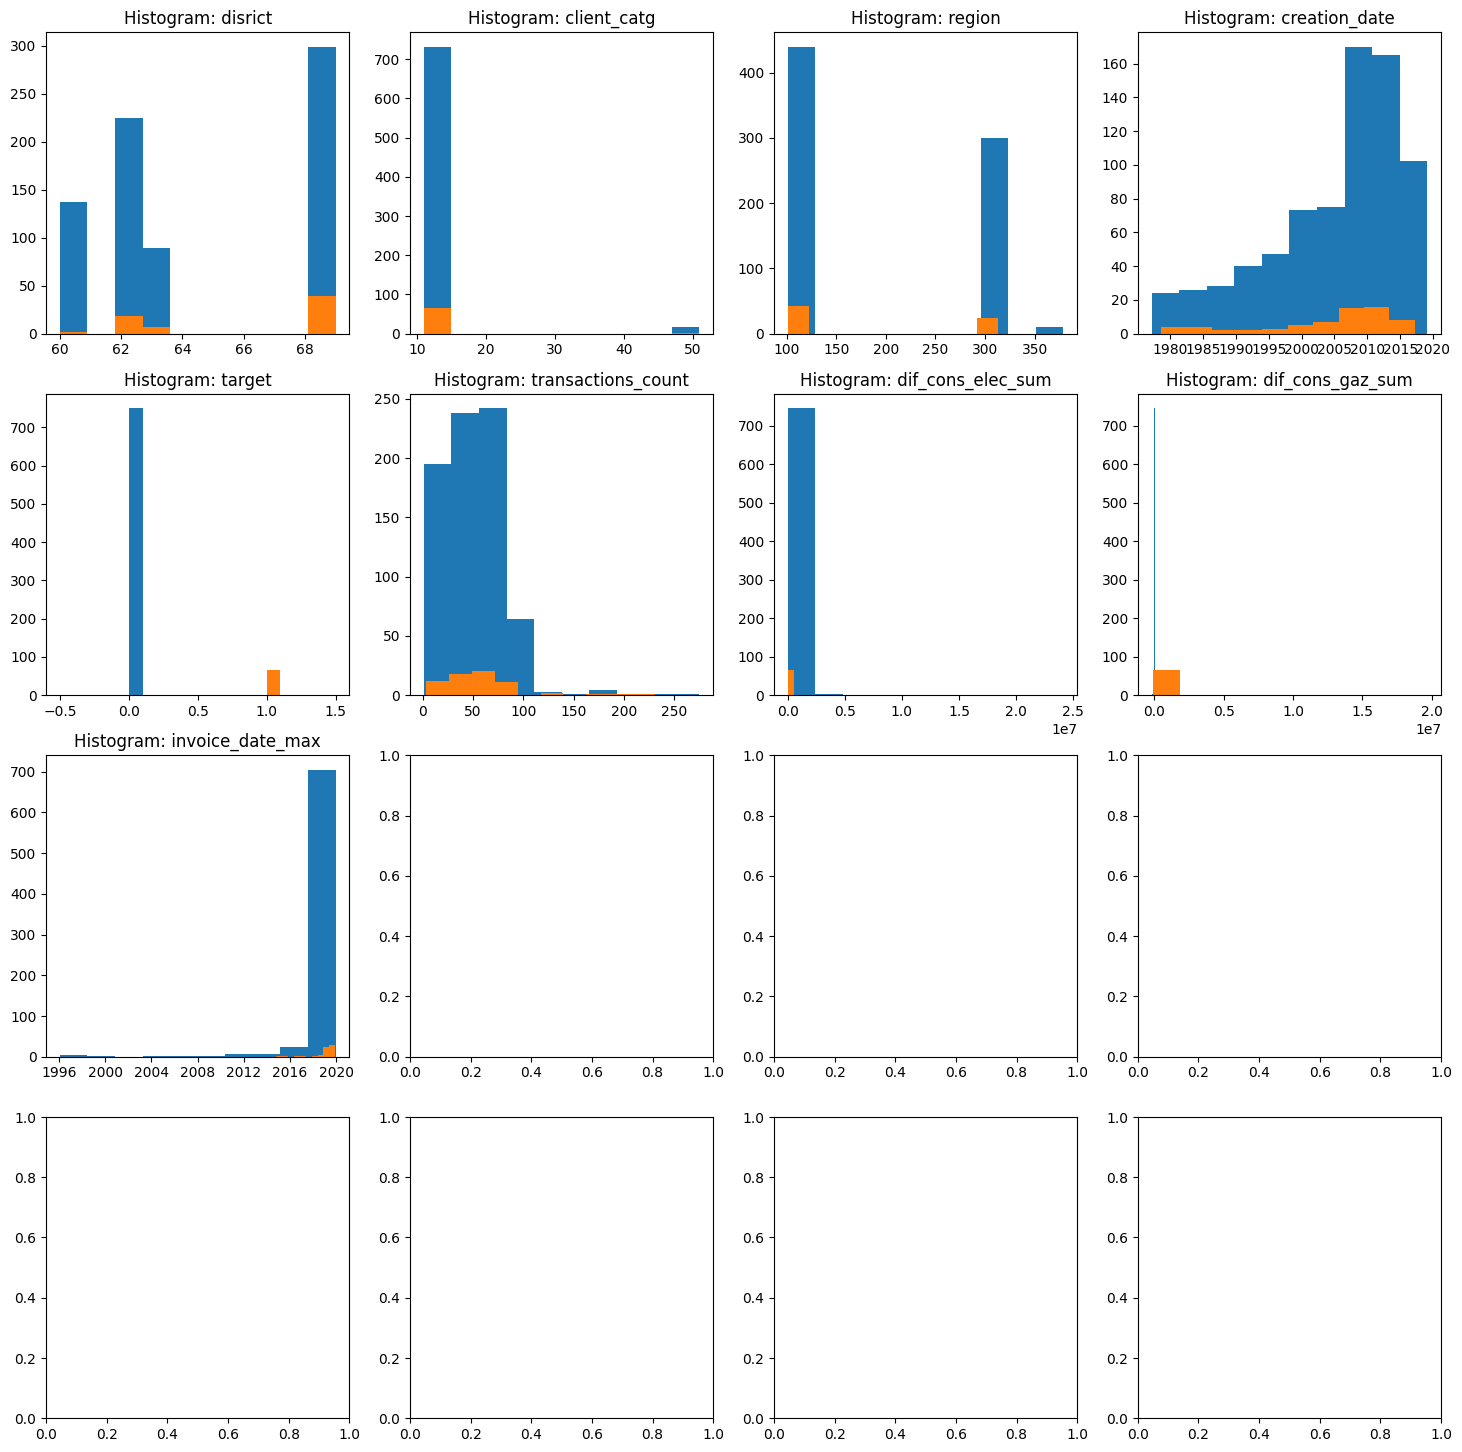

In [427]:
histplot_target(train[train.dif_cons_elec_sum>0],num_cols,4,4)

<Axes: >

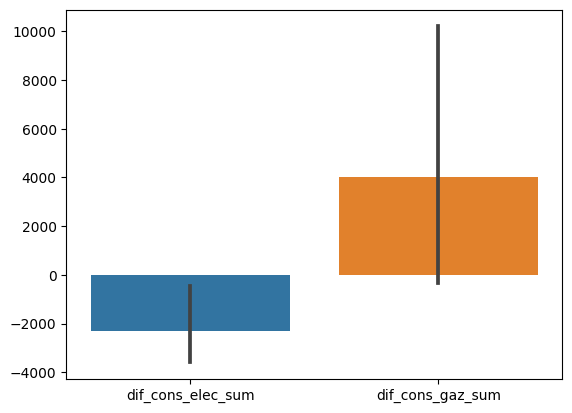

In [428]:
sns.barplot(train.loc[train.target == 1,['dif_cons_elec_sum','dif_cons_gaz_sum']])

<Axes: >

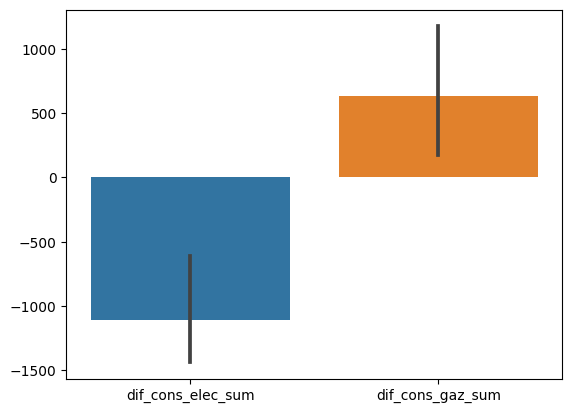

In [429]:
sns.barplot(train.loc[train.target == 0,['dif_cons_elec_sum','dif_cons_gaz_sum']])

(array([1.000e+00, 3.000e+00, 7.561e+03, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 1.000e+00]),
 array([-2000000., -1249044.,  -498088.,   252868.,  1003824.,  1754780.,
         2505736.,  3256692.,  4007648.,  4758604.,  5509560.]),
 <BarContainer object of 10 artists>)

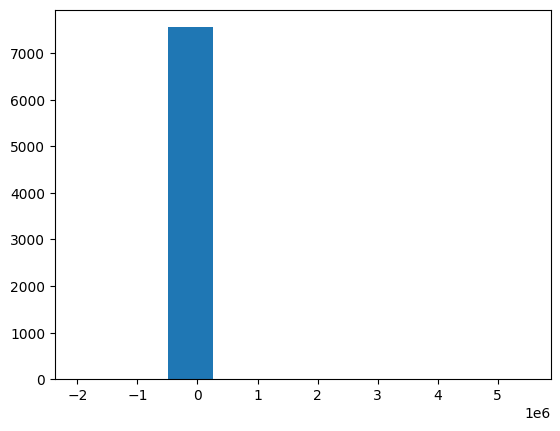

In [430]:
plt.hist(train.loc[train.target == 1,['dif_cons_elec_sum']])
#plt.hist(train.loc[train.target == 1,['dif_cons_gaz_sum']])


In [431]:
train.loc[(train.invoice_date_max.dt.year<=2010)&(train.target==1)].shape[0]

6

In [432]:
#sns.pairplot(data=train[train.target==1])

In [433]:
train[train.consommation_level_3_mean<=5]

AttributeError: 'DataFrame' object has no attribute 'consommation_level_3_mean'

In [ ]:
train.loc[train.target==1,'date_difference'].describe()

count    7.566000e+03
mean     3.450470e+17
std      1.150126e+17
min      0.000000e+00
25%      2.758104e+17
50%      4.084128e+17
75%      4.306824e+17
max      4.701888e+17
Name: date_difference, dtype: float64

In [ ]:
train['date_difference'].describe()

count    1.354930e+05
mean     2.612094e+17
std      1.596738e+17
min      0.000000e+00
25%      1.052352e+17
50%      2.936736e+17
75%      4.202496e+17
max      4.701888e+17
Name: date_difference, dtype: float64

# Modelling

## Train LGBM *Classifier*

In [ ]:
X = train.drop(columns=['target'])
y = train['target']

X_train,X_test,y_train,y_test = train_test_split(X,y,stratify=y)

In [ ]:
model = LGBMClassifier(boosting_type='gbdt', num_iterations=500)
model.fit(X_train, y_train)

TypeError: The DType <class 'numpy.dtype[float64]'> could not be promoted by <class 'numpy.dtype[datetime64]'>. This means that no common DType exists for the given inputs. For example they cannot be stored in a single array unless the dtype is `object`. The full list of DTypes is: (<class 'numpy.dtype[int64]'>, <class 'numpy.dtype[int64]'>, <class 'numpy.dtype[int64]'>, <class 'numpy.dtype[int64]'>, <class 'numpy.dtype[float64]'>, <class 'numpy.dtype[float64]'>, <class 'numpy.dtype[float64]'>, <class 'numpy.dtype[float64]'>, <class 'numpy.dtype[datetime64]'>, <class 'numpy.dtype[datetime64]'>, <class 'numpy.dtype[int64]'>, <class 'numpy.dtype[int64]'>, <class 'numpy.dtype[float64]'>, <class 'numpy.dtype[timedelta64]'>, <class 'numpy.dtype[float32]'>)

## Make Predictions on test set

In [ ]:
X_test.columns

Index(['disrict', 'client_catg', 'region', '1transactions_count',
       'consommation_level_1_mean', 'consommation_level_2_mean',
       'consommation_level_3_mean', 'consommation_level_4_mean'],
      dtype='object')

In [ ]:
preds = model.predict(X_test)
preds = pd.DataFrame(preds, columns=['target'])
preds.head()

,target
0,0.0
1,0.0
2,0.0
3,0.0
4,0.0


In [ ]:
cm = confusion_matrix(y_test, preds)
cm

array([[31920,    62],
       [ 1868,    24]])

In [ ]:
submission = pd.DataFrame(
    {
        'client_id': sub_client_id,
        'target': preds['target']
    }
)

submission.head()

,client_id,target
0,test_Client_0,0.0
1,test_Client_1,0.0
2,test_Client_10,0.0
3,test_Client_100,0.0
4,test_Client_1000,0.0


In [ ]:
# Create the model with 100 trees
model = RandomForestClassifier(n_estimators=100, 
                               random_state=RSEED, 
                               max_features = 'sqrt',
                               n_jobs=-1, verbose = 1)
model.fit(X_train, y_train)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    1.6s finished


RandomForestClassifier(n_jobs=-1, random_state=42, verbose=1)

In [ ]:
preds = model.predict(X_test)
cm = confusion_matrix(y_test, preds)
cm

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.1s finished


array([[31873,   109],
       [ 1870,    22]])

## Class Weight

In [ ]:
from sklearn.utils.class_weight import compute_class_weight
class_weights = compute_class_weight('balanced', classes=np.unique(y), y=y)
model = RandomForestClassifier(class_weight=dict(enumerate(class_weights)),n_estimators=100, 
                               random_state=RSEED, 
                               max_features = 'sqrt',
                               n_jobs=-1, verbose = 1)

model.fit(X_train, y_train)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    1.5s finished


RandomForestClassifier(class_weight={0: 0.52957155252605, 1: 8.9540708432461},
                       n_jobs=-1, random_state=42, verbose=1)

In [ ]:
preds = model.predict(X_test)
cm = confusion_matrix(y_test, preds)
cm

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.1s finished


array([[31859,   123],
       [ 1876,    16]])

### RandomOverSampler

In [ ]:
#!pip install imblearn

In [ ]:
from imblearn.over_sampling import RandomOverSampler

#RandomOverSampler
ros = RandomOverSampler()

X_resampled, y_resampled = ros.fit_resample(X_train, y_train)
print(X_train.shape, y_train.shape, X_resampled.shape, y_resampled.shape)

(101619, 8) (101619,) (191890, 8) (191890,)


In [ ]:
#X_train,X_test,y_train,y_test = train_test_split(X_resampled, y_resampled,stratify=y_resampled)
model = LGBMClassifier(boosting_type='gbdt', num_iterations=500)
model.fit(X_train, y_train)

[LightGBM] [Info] Number of positive: 5674, number of negative: 95945
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001788 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1252
[LightGBM] [Info] Number of data points in the train set: 101619, number of used features: 8
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.055836 -> initscore=-2.827881
[LightGBM] [Info] Start training from score -2.827881


LGBMClassifier(num_iterations=500)

In [ ]:
preds = model.predict(X_test)
cm = confusion_matrix(y_test, preds)
cm

array([[31920,    62],
       [ 1868,    24]])

In [ ]:
model = RandomForestClassifier(n_estimators=100, 
                               random_state=RSEED, 
                               max_features = 'sqrt',
                               n_jobs=-1, verbose = 1)

model.fit(X_train, y_train)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    1.6s finished


RandomForestClassifier(n_jobs=-1, random_state=42, verbose=1)

In [ ]:
preds = model.predict(X_test)
cm = confusion_matrix(y_test, preds)
cm

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.1s finished


array([[31873,   109],
       [ 1870,    22]])

In [ ]:
from imblearn.over_sampling import SMOTE

# SMOTE
smote = SMOTE()

X_resampled, y_resampled = smote.fit_resample(X_train, y_train)
print(X_train.shape, y_train.shape, X_resampled.shape, y_resampled.shape)

(101619, 8) (101619,) (191890, 8) (191890,)


In [ ]:
#X_train,X_test,y_train,y_test = train_test_split(X_resampled, y_resampled,stratify=y_resampled)
model = LGBMClassifier(boosting_type='gbdt', num_iterations=500)
model.fit(X_train, y_train)

[LightGBM] [Info] Number of positive: 5674, number of negative: 95945
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001443 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1252
[LightGBM] [Info] Number of data points in the train set: 101619, number of used features: 8
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.055836 -> initscore=-2.827881
[LightGBM] [Info] Start training from score -2.827881


LGBMClassifier(num_iterations=500)

In [ ]:
preds = model.predict(X_test)
cm = confusion_matrix(y_test, preds)
cm

array([[31920,    62],
       [ 1868,    24]])

In [ ]:
model = RandomForestClassifier(n_estimators=100, 
                               random_state=RSEED, 
                               max_features = 'sqrt',
                               n_jobs=-1, verbose = 1)

model.fit(X_train, y_train)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    1.7s finished


RandomForestClassifier(n_jobs=-1, random_state=42, verbose=1)

In [ ]:
preds = model.predict(X_test)
cm = confusion_matrix(y_test, preds)
cm

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.1s finished


array([[31873,   109],
       [ 1870,    22]])

In [ ]:
from imblearn.over_sampling import ADASYN

# ADASYN
adasyn = ADASYN()

X_resampled, y_resampled = adasyn.fit_resample(X_train, y_train)

In [ ]:
#X_train,X_test,y_train,y_test = train_test_split(X_resampled, y_resampled,stratify=y_resampled)
model = LGBMClassifier(boosting_type='gbdt', num_iterations=500)
model.fit(X_train, y_train)

[LightGBM] [Info] Number of positive: 5674, number of negative: 95945
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001717 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1252
[LightGBM] [Info] Number of data points in the train set: 101619, number of used features: 8
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.055836 -> initscore=-2.827881
[LightGBM] [Info] Start training from score -2.827881


LGBMClassifier(num_iterations=500)

In [ ]:
preds = model.predict(X_test)
cm = confusion_matrix(y_test, preds)
cm

array([[31920,    62],
       [ 1868,    24]])

In [ ]:
model = RandomForestClassifier(n_estimators=100, 
                               random_state=RSEED, 
                               max_features = 'sqrt',
                               n_jobs=-1, verbose = 1)

model.fit(X_train, y_train)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    1.6s finished


RandomForestClassifier(n_jobs=-1, random_state=42, verbose=1)

In [ ]:
preds = model.predict(X_test)
cm = confusion_matrix(y_test, preds)
cm

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.1s finished


array([[31873,   109],
       [ 1870,    22]])